1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [10]:
# If haven't downloaded it yet, please get the data file with wget
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

--2023-11-19 10:49:52--  https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt
Resolving www.dropbox.com... 162.125.69.18
Connecting to www.dropbox.com|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/xvjzaxzz3ysphme/data_000637.txt [following]
--2023-11-19 10:49:52--  https://www.dropbox.com/s/raw/xvjzaxzz3ysphme/data_000637.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9f4b7346d94af2bc360cff1cfd.dl.dropboxusercontent.com/cd/0/inline/CH1BgftvMsyxHpIM8Bq8-nrLJqxB9cMiVYBoss1fd71Iiq-0imlV_ub2CTZaOkq4sd5y_jJDj3A0pFS-_vmbrdZV8i2VawWZrld9uzcZP0PK5CtNfDQL28-5mjV4vLGgJYk/file# [following]
--2023-11-19 10:49:52--  https://uc9f4b7346d94af2bc360cff1cfd.dl.dropboxusercontent.com/cd/0/inline/CH1BgftvMsyxHpIM8Bq8-nrLJqxB9cMiVYBoss1fd71Iiq-0imlV_ub2CTZaOkq4sd5y_jJDj3A0pFS-_vmbrdZV8i2VawWZrld9uzcZP0PK5CtNfDQL28-5mjV4vLGgJYk/file
Resolving uc9f4b7346d94af2bc360cff1cfd.

In [2]:
import pandas as pd
import numpy as np
import datetime as dt

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [5]:
file_name = "data/data_000637.txt"
read_data = pd.read_csv(file_name)
N = int(read_data.shape[0] / 2)
data = read_data.copy()
data = data[:N]
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
655355,1,0,36,3869206669,880,0
655356,1,0,40,3869206669,878,23
655357,1,0,124,3869206669,881,2
655358,1,0,60,3869206669,875,5


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [6]:
bx_count = data.loc[:,'BX_COUNTER']
mylist = np.array([])
for i in range(bx_count.shape[0]):
    if bx_count[i] == 0:
        x = bx_count[i-1]
        mylist = np.append(mylist, x)
print("The estimated number of Bx in a ORBIT is:", round(mylist.mean(),3))

# OR ????

x = bx_count.max()
print("The estimated number of Bx in a ORBIT is:", x)

The estimated number of Bx in a ORBIT is: 2035.613
The estimated number of Bx in a ORBIT is: 3563


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

*Hint:* introduce an offset to the absolute time such that the start of the data acquisition (i.e. the first entry) is zero.

In [7]:
data["ABS_TIME"] = (data['TDC_MEAS'] * 25/30) + (data['BX_COUNTER'] * 25) + (data['ORBIT_CNT'] * x * 25)
data["TIME_SERIES"] = pd.to_datetime(data["ABS_TIME"], unit='ns')
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME,TIME_SERIES
0,1,0,123,3869200167,2374,26,3.446490e+14,1970-01-04 23:44:09.004934896
1,1,0,124,3869200167,2374,27,3.446490e+14,1970-01-04 23:44:09.004934897
2,1,0,63,3869200167,2553,28,3.446490e+14,1970-01-04 23:44:09.004939373
3,1,0,64,3869200167,2558,19,3.446490e+14,1970-01-04 23:44:09.004939490
4,1,0,64,3869200167,2760,25,3.446490e+14,1970-01-04 23:44:09.004944545
...,...,...,...,...,...,...,...,...
655355,1,0,36,3869206669,880,0,3.446496e+14,1970-01-04 23:44:09.584063175
655356,1,0,40,3869206669,878,23,3.446496e+14,1970-01-04 23:44:09.584063144
655357,1,0,124,3869206669,881,2,3.446496e+14,1970-01-04 23:44:09.584063201
655358,1,0,60,3869206669,875,5,3.446496e+14,1970-01-04 23:44:09.584063054


4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [8]:
duration = data.at[data.shape[0] - 1, 'TIME_SERIES'] - data.at[0, 'TIME_SERIES']
print("The duration is:", duration)

The duration is: 0 days 00:00:00.579128489


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [9]:
noisy_ch = data.groupby('TDC_CHANNEL')['TDC_CHANNEL'].count().sort_values(ascending=False).head(3)
noisy_ch

TDC_CHANNEL
139    54435
64     32810
63     32178
Name: TDC_CHANNEL, dtype: int64

6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [10]:
counting = data.groupby('ORBIT_CNT')['ORBIT_CNT'].count().sort_values()
print("The lowest orbit has value:", counting.head(1).values)
print("So, the number of non-empty orbits is the number of orbits itself:", counting.shape[0])

The lowest orbit has value: [1]
So, the number of non-empty orbits is the number of orbits itself: 6499


In [11]:
uniq = data.groupby('TDC_CHANNEL')['ORBIT_CNT'].unique()
print("The number of unique orbits from TDC_CHANNEL=139 is:", len(uniq[139]))

The number of unique orbits from TDC_CHANNEL=139 is: 6474


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [28]:
mask1 = data['FPGA'] == 0
mask2 = data['FPGA'] == 1
FPGA1 = data[mask1].groupby('TDC_CHANNEL')['TDC_CHANNEL'].count()
FPGA2 = data[mask2].groupby('TDC_CHANNEL')['TDC_CHANNEL'].count()
print(FPGA1)
print("\n")
print(FPGA2)

TDC_CHANNEL
1        612
2        777
3        763
4       1168
5        725
       ...  
129        2
130       14
137       12
138       13
139    38149
Name: TDC_CHANNEL, Length: 124, dtype: int64


TDC_CHANNEL
1      14169
2      16242
3      10978
4      13106
5       7463
       ...  
129       14
130       17
137       15
138       15
139    16286
Name: TDC_CHANNEL, Length: 132, dtype: int64


9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

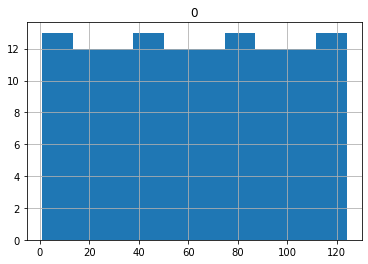

In [52]:
import matplotlib.pyplot as plt
ax1 = np.linspace(1,len(FPGA1),len(FPGA1))
df1 = pd.DataFrame(ax1, index=FPGA1.values)
hist = df1.hist()


